# Data augmentation for multivariate time series classification(MTS)
> Based on K-NN & DTW(Dynamic Time Warping)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<br/>
<br/>
<br/>
<br/>

## Load Data

In [2]:
from sktime.utils.data_io import load_from_tsfile_to_dataframe

data_name = 'Epilepsy'

x_train, y_train = load_from_tsfile_to_dataframe(f'datasets/{data_name}/{data_name}_TRAIN.ts') 
x_test, y_test = load_from_tsfile_to_dataframe(f'datasets/{data_name}/{data_name}_TEST.ts')

</br>
</br>

<br/>
<br/>

- 각 데이터마다 길이 206의 Series가 들어가있음

In [3]:
x_train['class'] = y_train
display(x_train.head(3), x_train.tail(3))
del x_train['class']

,dim_0,dim_1,dim_2,class
0,0 0.35 1 0.40 2 0.44 3 0.4...,0 0.22 1 0.01 2 -0.71 3 -0.3...,0 0.55 1 0.51 2 0.52 3 0.4...,epilepsy
1,0 -0.91 1 -0.92 2 -0.95 3 -0.9...,0 -0.05 1 -0.02 2 0.01 3 0.0...,0 0.06 1 -1.57 2 -0.99 3 0.2...,epilepsy
2,0 0.32 1 0.71 2 0.70 3 0.7...,0 1.00 1 -1.33 2 -1.44 3 -0.1...,0 0.37 1 0.37 2 0.37 3 0.3...,epilepsy


,dim_0,dim_1,dim_2,class
134,0 1.16 1 -0.02 2 -1.04 3 -0.8...,0 0.90 1 0.59 2 0.52 3 0.2...,0 -1.03 1 -1.11 2 -0.88 3 -0.9...,sawing
135,0 -0.74 1 -0.14 2 0.12 3 -0.0...,0 -0.19 1 -0.24 2 -0.34 3 -0.6...,0 -0.14 1 -0.26 2 -0.27 3 -0.3...,sawing
136,0 1.06 1 1.14 2 0.37 3 -0.2...,0 -1.40 1 -1.13 2 -0.59 3 -0.3...,0 -0.26 1 -0.22 2 -0.48 3 -0.5...,sawing


In [4]:
x_train.iloc[0,0]

0      0.35
1      0.40
2      0.44
3      0.47
4      0.48
       ... 
201    0.58
202    0.61
203    0.62
204    0.65
205    0.69
Length: 206, dtype: float64

<br/>
<br/>

- np.array로 변환

In [5]:
array = []
for row in range(len(x_train)) :
    arr = np.array([x_train.iloc[row, col].to_numpy() for col in range(x_train.shape[1])])
    array.append(np.transpose(arr))

x_train = np.array(array)
del array

x_train.shape

(137, 206, 3)

In [6]:
num_replicates, len_series, num_dim = x_train.shape
classes = np.unique(y_train)

print(f'# replicates : {num_replicates}')
print(f'# dimensions : {num_dim}')
print(f'length of series : {len_series}')
print(f'class : {classes}')

# replicates : 137
# dimensions : 3
length of series : 206
class : ['epilepsy' 'running' 'sawing' 'walking']


<br/>
<br/>
<br/>
<br/>

## Data Generate
1. class 별
2. KNN 적용 based on DTW distance
3. 데이터 1개 샘플링
4. 근접한 K개 데이터 추출
5. 새로운 데이터 1개 생성

In [7]:
%%time
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.barycenters import softdtw_barycenter
from tslearn.metrics import dtw, gamma_soft_dtw

# 생성할 데이터 개수
num_synthetic_ts = 1000

# KNN 적용할 최대 K 값
max_neighbors = 5

# 생성한 데이터 담을 리스트
synthetic_x_train = []
synthetic_y_train = []


for c in classes : # classes : ['epilepsy' 'running' 'sawing' 'walking']
    # 한 class만 선택
    c_x_train = x_train[np.where(y_train == c)]

    # class 별 데이터가 1개면 continue
    if len(c_x_train) == 1 :
        continue
    
    class_gamma = gamma_soft_dtw(c_x_train)
    
    cnt = 0
    
    while cnt < num_synthetic_ts : # 하나씩 생성
        # KNN based on DTW
        random_n_neighbors = np.random.randint(1, max_neighbors) + 1 # range : 2 ~ max_neighbors
        knn = KNeighborsTimeSeries(n_neighbors=random_n_neighbors,
                                   metric = 'softdtw',
                                   metric_params = {'gamma' : class_gamma})
        knn.fit(c_x_train)
        
        
        # 데이터 1개 샘플링
        random_idx = np.random.choice(np.arange(len(c_x_train)), 1)
        random_sample = c_x_train[random_idx]
        
        
        # 근접한 데이터 구하기
        distances, indices = knn.kneighbors(random_sample, return_distance=True)
        distances = distances[0] # 거리
        indices = indices[0] # 인덱스
        
        neighbors = c_x_train[indices]
        
        # 최근접 거리
        nearest_distance = np.sort(distances)[1] # 0번은 자기 자신
        
        # 가중치 based on 거리
        weights = np.exp(np.log(0.5) * distances / nearest_distance)
        weights /= np.sum(weights) # normalize
        
        # 새로운 데이터 생성
        neighbors_gamma = gamma_soft_dtw(neighbors)
        new_sample = softdtw_barycenter(neighbors,
                                        weights = weights,
                                        gamma = neighbors_gamma)
        
        # 리스트에 저장
        synthetic_x_train.append(new_sample)
        synthetic_y_train.append(c)
        
        
        cnt += 1
        
synthetic_x_train = np.array(synthetic_x_train)
synthetic_y_train = np.array(synthetic_y_train)

print(f'New X shape : {synthetic_x_train.shape}')
print(f'New Y shape : {synthetic_y_train.shape}')

New X shape : (4000, 206, 3)
New Y shape : (4000,)
Wall time: 9min 6s


<br/>
<br/>
<br/>
<br/>

## 위 반복문에서 한 클래스('epilepsy')만 실행

In [8]:
c_x_train = x_train[np.where(y_train == 'epilepsy')]
c_x_train.shape

(34, 206, 3)

In [9]:
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.barycenters import softdtw_barycenter
from tslearn.metrics import gamma_soft_dtw

class_gamma = gamma_soft_dtw(c_x_train)

# KNN 적용할 최대 K 값
max_neighbors = 5

<br/>
<br/>

- KNN based on DTW

In [10]:
random_n_neighbors = np.random.randint(1, max_neighbors) + 1 # range : 2 ~ max_neighbors
random_n_neighbors = 3 # 일단 3개 기준

knn = KNeighborsTimeSeries(n_neighbors = random_n_neighbors,
                           metric = 'softdtw',
                           metric_params = {'gamma' : class_gamma})

knn.fit(c_x_train)

KNeighborsTimeSeries(metric='softdtw',
                     metric_params={'gamma': 1025.9623933820574},
                     n_neighbors=3)

<br/>
<br/>

- 데이터 1개 샘플링 후 근접한 K개 데이터 구하기

In [11]:
# 데이터 1개 샘플링
random_idx = np.random.choice(np.arange(len(c_x_train)), 1)
random_representative = c_x_train[random_idx]

# 근접한 데이터 구하기
distances, indices = knn.kneighbors(X = random_representative, return_distance = True)
distances, indices = distances[0], indices[0]

print(f'From {random_idx[0]} index')
display(pd.DataFrame({'Indices' : indices, 'Distances' : distances}))

From 6 index


,Indices,Distances
0,6,-367329.305519
1,32,-367026.276531
2,31,-367022.309482


In [12]:
# 최근접 거리
nearest_distance = np.sort(distances)[1]
nearest_distance

-367026.2765314193

In [13]:
# 근접 데이터
random_neighbors = c_x_train[indices]
random_neighbors.shape

(3, 206, 3)

In [14]:
# 가중치 based on 거리
weights = np.exp(np.log(0.5)*distances/nearest_distance) # 0.5 ** (distances/nearest_distance)
weights /= np.sum(weights)
weights

array([0.33320534, 0.33339608, 0.33339858])

In [15]:
gamma = gamma_soft_dtw(random_neighbors)
gamma

420.4871999999999

<br/>
<br/>

- 새로운 데이터 생성

In [16]:
generated_sample = softdtw_barycenter(random_neighbors, weights=weights, gamma=gamma)
generated_sample.shape

(206, 3)

</br>
</br>
</br>
</br>

<br/>
<br/>
<br/>
<br/>

## 시각화
- 빨간색 : 생성된 데이터
- 주황색 : 기존 데이터

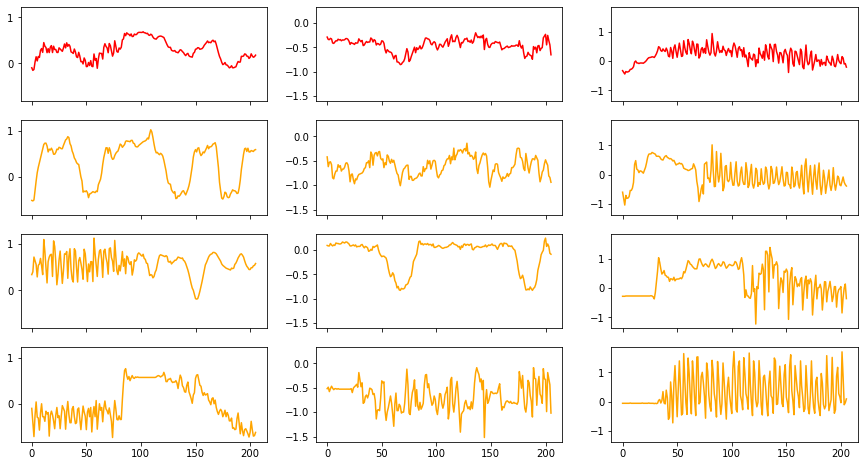

In [17]:
rows = random_neighbors.shape[0] + 1
cols = random_neighbors.shape[2]

fig, ax = plt.subplots(rows, cols,
                       sharex = True,
                       sharey = 'col',
                       figsize = (cols * 5, rows * 2))

for j in range(cols) :
    ax[0,j].plot(generated_sample[:, j], c = 'r')

for i in range(rows-1) :
    for j in range(cols) :
        ax[i+1,j].plot(random_neighbors[i,:,j], c = 'orange')
        
        
plt.show()

<br/>
<br/>

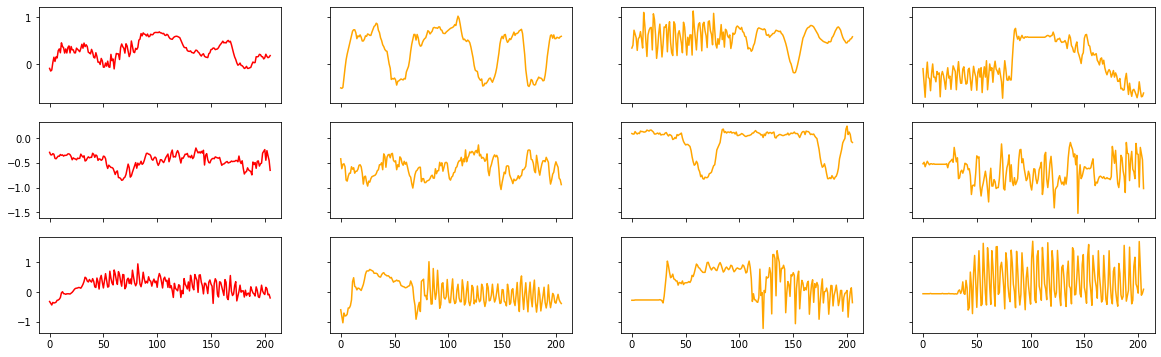

In [18]:
rows = random_neighbors.shape[2]
cols = random_neighbors.shape[0] + 1

fig, ax = plt.subplots(rows, cols,
                       sharex = True,
                       sharey = 'row',
                       figsize = (cols * 5, rows * 2))

for i in range(rows) :
    ax[i,0].plot(generated_sample[:, i], c = 'r')

for i in range(rows) :
    for j in range(cols-1) :
        ax[i,j+1].plot(random_neighbors[j,:,i], c = 'orange')
        
        
plt.show()

<br/>
<br/>
<br/>
<br/>

### References
- https://github.com/npschafer/MTS-DA